In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = ''
import sys
sys.path.append('../../')
import numpy as np
import sexpdata

from models_vqa.nmn3_assembler import Assembler

In [2]:
def extract_parse(p):
    if isinstance(p, sexpdata.Symbol):
        return p.value()
    elif isinstance(p, int):
        return str(p)
    elif isinstance(p, bool):
        return str(p).lower()
    elif isinstance(p, float):
        return str(p).lower()
    return tuple(extract_parse(q) for q in p)

def parse_tree(p):
    if "'" in p:
        p = "none"
    parsed = sexpdata.loads(p)
    extracted = extract_parse(parsed)
    return extracted

parse2module_dict = {
    'find': '_Find',
    'relate': '_Transform',
    'and': '_And',
    'is': '_Describe', # All the top modules go to '_Describe'
    'describe': '_Describe'
}
def flatten_layout(parse):
    # Postorder traversal to generate Reverse Polish Notation (RPN)
    if isinstance(parse, str):
        return [parse2module_dict[parse]]
    RPN = []
    head = parse[0]
    body = parse[1:]
    module = parse2module_dict[head]
    for m in body:
        RPN += flatten_layout(m)
    RPN += [module]
    return RPN

In [3]:
qid_file = './parse/new_parse/%s.ids.txt'
parse_file = './parse/new_parse/%s.questions.sp'
save_file = './gt_layout_%s_new_parse.npy'

assembler = Assembler('./vocabulary_layout.txt')

def extract_set(image_set):
    with open(qid_file % image_set) as f:
        qids = [eval(s)[0] for s in f.readlines()]
    with open(parse_file % image_set) as f:
        layouts = [flatten_layout(parse_tree(l)) for l in f.readlines()]
        
    layout_set = {tuple(l) for l in layouts}
    print('found %d unique layouts on split %s' % (len(layout_set), image_set))
    for l in layout_set:
        print(' ', ' '.join(list(l)))
    # check whether the layout is valid
    for l in layout_set:
        batch = np.array(assembler.module_list2tokens(l, T=20))[:, np.newaxis]
        expr, validity = assembler.assemble(batch)
        if not np.all(validity):
            raise Exception('invalid expr:' + str(expr[0]))
    
    qid2layout_dict = {qid:layout for qid, layout in zip(qids, layouts)}
    np.save(save_file % image_set, np.array(qid2layout_dict))
    
    set_layout_length = [len(l) for l in layouts]
    return set_layout_length

In [4]:
layout_length = []  # collect results on layout length
for image_set in ['train2014', 'val2014']:
    layout_length += extract_set(image_set)

found 24 unique layouts on split train2014
  _Find _Transform _Find _Find _And _Transform _And _Transform _Describe
  _Find _Find _And _Describe
  _Find _Find _And _Transform _Find _And _Describe
  _Find _Find _Find _Transform _And _Transform _And _Describe
  _Find _Find _Find _Transform _Transform _And _Transform _And _Describe
  _Find _Transform _Transform _Find _Transform _And _Describe
  _Find _Transform _Transform _Find _And _Describe
  _Find _Find _Find _And _Transform _Find _And _Transform _And _Describe
  _Find _Find _Find _And _Transform _And _Describe
  _Find _Transform _Describe
  _Find _Find _Find _And _Transform _Find _Transform _And _Transform _And _Describe
  _Find _Transform _Transform _Describe
  _Find _Find _Transform _And _Transform _Describe
  _Find _Find _Transform _And _Describe
  _Find _Find _And _Transform _Describe
  _Find _Find _Find _Find _And _Transform _And _Transform _And _Describe
  _Find _Find _Transform _Find _And _Transform _And _Describe
  _Find _Find

max layout length: 12


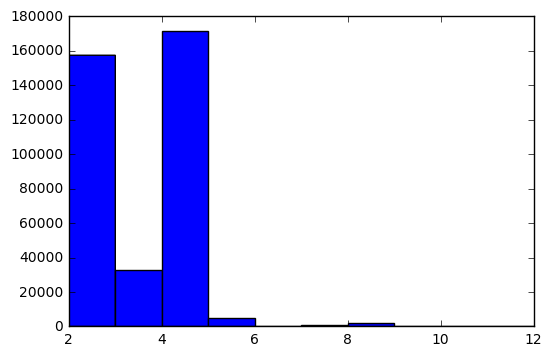

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
print('max layout length:', max(layout_length))
_ = plt.hist(layout_length)